## Import libraries

In [44]:
!pip install -q yfinance
import math
import pandas_datareader as web
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

yf.pdr_override()

# For time stamps
from datetime import datetime

plt.style.use('fivethirtyeight')

## Loading data

In [45]:
# Pulled data from Yahoo Finance
# Get the stock quote
df = pdr.get_data_yahoo('KAEF.JK', start='2022-01-01', end=datetime.now())
df.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-26,745.0,755.0,735.0,735.0,735.0,360500
2024-04-29,735.0,760.0,725.0,745.0,745.0,689900
2024-04-30,745.0,770.0,740.0,755.0,755.0,740600
2024-05-02,720.0,755.0,680.0,725.0,725.0,1256100
2024-05-03,730.0,775.0,730.0,735.0,735.0,2684900


In [46]:
print('Number of rows and columns: ', df.shape) #Check number of rows and columns
print("checking if any null values are present\n", df.isna().sum()) #Check for Missing values

Number of rows and columns:  (561, 6)
checking if any null values are present
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


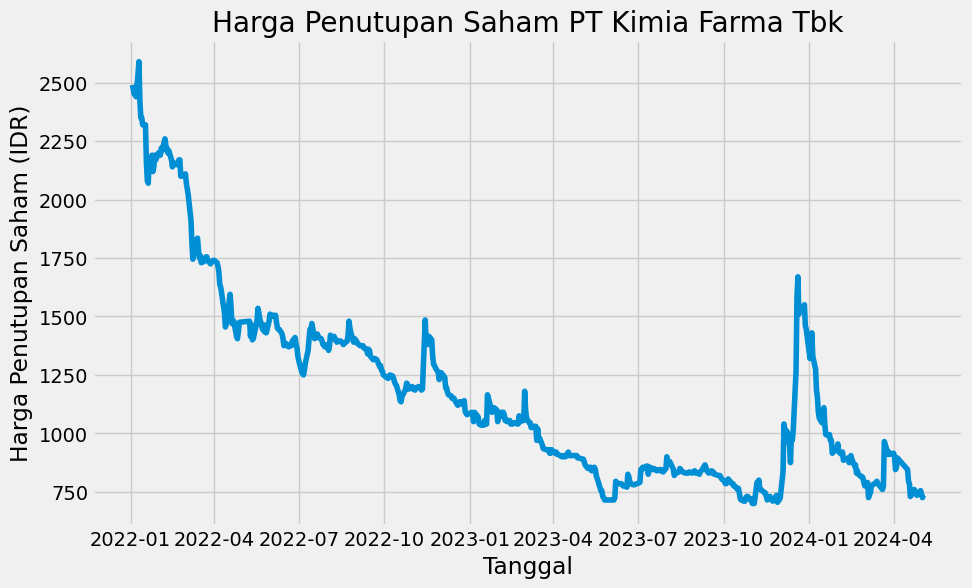

In [63]:
plt.figure(figsize = (10,6))
plt.plot(df["Close"])
plt.title('Harga Penutupan Saham PT Kimia Farma Tbk')
plt.ylabel('Harga Penutupan Saham (IDR)')
plt.xlabel('Tanggal')
plt.savefig('saham_kaef.png')
plt.show()

In [48]:
df["Close"].max(), df["Close"].min() # find min value and max value in column 'Close'

(2590.0, 700.0)

In [49]:
# Create a dataframe with only the Close Stock Price Column
# Target Variable: Close stock price value
data_target = df.filter(['Close'])

# Convert the dataframe to a numpy array to train the LSTM model
target = data_target.values

# Splitting the dataset into training and test

training_data_len = math.ceil(len(target)* 0.80) # training set has 75% of the data
training_data_len

# Normalizing data before model fitting using MinMaxScaler
# Feature Scaling

sc = MinMaxScaler(feature_range=(0,1))
training_scaled_data = sc.fit_transform(target)
training_scaled_data

array([[0.94708995],
       [0.93650794],
       [0.92592593],
       [0.94179894],
       [0.92063492],
       [1.        ],
       [0.91005291],
       [0.87301587],
       [0.87301587],
       [0.85714286],
       [0.85714286],
       [0.77248677],
       [0.73015873],
       [0.72486772],
       [0.77777778],
       [0.78835979],
       [0.75132275],
       [0.76190476],
       [0.78835979],
       [0.77777778],
       [0.79365079],
       [0.78835979],
       [0.8042328 ],
       [0.7989418 ],
       [0.82539683],
       [0.80952381],
       [0.8042328 ],
       [0.79365079],
       [0.7989418 ],
       [0.77777778],
       [0.76190476],
       [0.77248677],
       [0.76719577],
       [0.76719577],
       [0.76719577],
       [0.77777778],
       [0.77777778],
       [0.74074074],
       [0.74074074],
       [0.74603175],
       [0.72486772],
       [0.6984127 ],
       [0.64021164],
       [0.58730159],
       [0.55291005],
       [0.57142857],
       [0.58994709],
       [0.600

In [50]:
# Create a training dataset containing the last 10-day closing price values we want to use to estimate the 11st closing price value.
train_data = training_scaled_data[0:training_data_len, : ]

X_train = []
y_train = []
for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train) # converting into numpy sequences to train the LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print('Number of rows and columns: ', X_train.shape)

Number of rows and columns:  (389, 60, 1)


In [53]:
# We add the LSTM layer and later add a few Dropout layers to prevent overfitting.
# Building a LTSM model with 50 neurons and 4 hidden layers. We add the LSTM layer with the following arguments:
# 50 units which is the dimensionality of the output space
# return_sequences=True which determines whether to return the last output in the output sequence, or the full sequence input_shape as the shape of our training set.
# When defining the Dropout layers, we specify 0.2, meaning that 20% of the layers will be dropped.
# Thereafter, we add the Dense layer that specifies the output of 1 unit.
# After this, we compile our model using the popular adam optimizer and set the loss as the mean_squarred_error.

model = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
13/13 [==============================] - 9s 103ms/step - loss: 0.0159
Epoch 2/100
13/13 [==============================] - 2s 146ms/step - loss: 0.0041
Epoch 3/100
13/13 [==============================] - 2s 134ms/step - loss: 0.0034
Epoch 4/100
13/13 [==============================] - 1s 100ms/step - loss: 0.0028
Epoch 5/100
13/13 [==============================] - 1s 99ms/step - loss: 0.0024
Epoch 6/100
13/13 [==============================] - 1s 100ms/step - loss: 0.0025
Epoch 7/100
13/13 [==============================] - 1s 102ms/step - loss: 0.0022
Epoch 8/100
13/13 [==============================] - 1s 99ms/step - loss: 0.0021
Epoch 9/100
13/13 [==============================] - 1s 99ms/step - loss: 0.0018
Epoch 10/100
13/13 [==============================] - 1s 99ms/step - loss: 0.0020
Epoch 11/100
13/13 [==============================] - 2s 155ms/step - loss: 0.0019
Epoch 12/100
13/13 [==============================] - 2s 139ms/step - loss: 0.0019
Epoch 13/100
13/1

In [54]:
# Getting the predicted stock price
test_data = training_scaled_data[training_data_len - 60: , : ]

#Create the x_test and y_test data sets
X_test = []
y_test =  target[training_data_len : , : ]
for i in range(60,len(test_data)):
    X_test.append(test_data[i-60:i,0])

# Convert x_test to a numpy array
X_test = np.array(X_test)

#Reshape the data into the shape accepted by the LSTM
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
print('Number of rows and columns: ', X_test.shape)

Number of rows and columns:  (112, 60, 1)


In [55]:
# Making predictions using the test dataset
y_pred = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(y_pred)

4/4 [==============================] - 2s 32ms/step


<ipython-input-64-d2a37641768c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predicted_stock_price


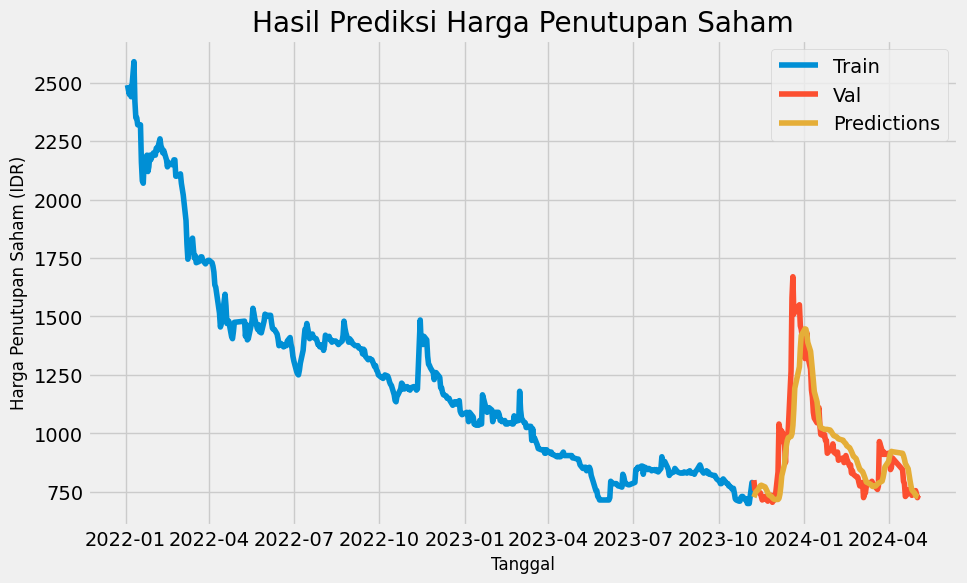

In [64]:
# Visualising the results
train = data_target[:training_data_len]
valid = data_target[training_data_len:]
valid['Predictions'] = predicted_stock_price
plt.figure(figsize=(10,6))
plt.title('Hasil Prediksi Harga Penutupan Saham')
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Harga Penutupan Saham (IDR)', fontsize=12)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')
plt.savefig('saham_kaef_predicted.png')
plt.show()

In [57]:
def compute_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

y_test = np.squeeze(y_test)

# Compute MAPE
mape = compute_mape(y_test, predicted_stock_price)
print("Mean Absolute Percentage Error (MAPE):", mape)

Mean Absolute Percentage Error (MAPE): 21.925750046313485


In [58]:
valid

,Close,Predictions
Date,,
2023-11-08,800.0,726.807068
2023-11-09,760.0,736.560242
2023-11-10,760.0,748.766479
2023-11-13,750.0,760.792664
2023-11-14,745.0,770.389771
...,...,...
2024-04-26,735.0,757.946472
2024-04-29,745.0,744.057495
2024-04-30,755.0,734.661926


In [59]:
#Make predictions for the next week
last_60_days = test_data[-60:]
next_week_predictions = []

for _ in range(7):
    predicted_price = model.predict(last_60_days.reshape(1, 60, 1))
    next_week_predictions.append(predicted_price[0][0])
    last_60_days = np.append(last_60_days[1:], predicted_price)

1/1 [==============================] - 0s 45ms/step


In [60]:
#Inverse transform the predicted values/Denormalize predicted prices
predicted_prices = sc.inverse_transform(np.array(next_week_predictions).reshape(-1, 1))

In [61]:
print("next week predictions:", predicted_prices)

next week predictions: [[728.78516]
 [730.46967]
 [732.6105 ]
 [734.8954 ]
 [737.2198 ]
 [739.6018 ]
 [742.0803 ]]
